In [ ]:
pip install --upgrade scikit-learn

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/fetal_health.csv')

In [ ]:
# Check class distribution
print("\nClass Distribution:")
df['fetal_health'].value_counts()


Class Distribution:


,count
fetal_health,
1.0,1655
2.0,295
3.0,176


In [ ]:
# Separate features and target
X = df.drop(columns=['fetal_health'])
y = df['fetal_health']

In [ ]:
column_names = df.columns
print(column_names)

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')


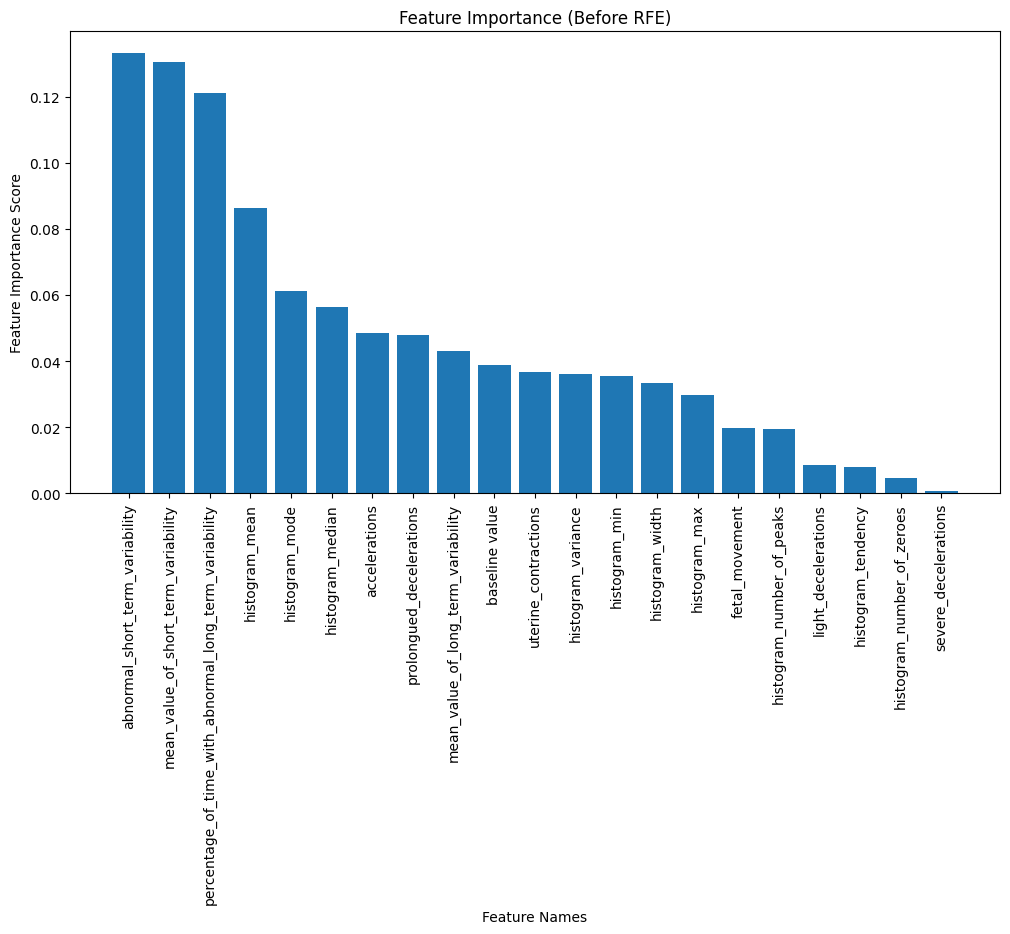

In [ ]:
# 1 Feature Importance Graph BEFORE RFE (All Features)
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(X.columns)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(X.columns)), X.columns[sorted_idx], rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance (Before RFE)')
plt.show()

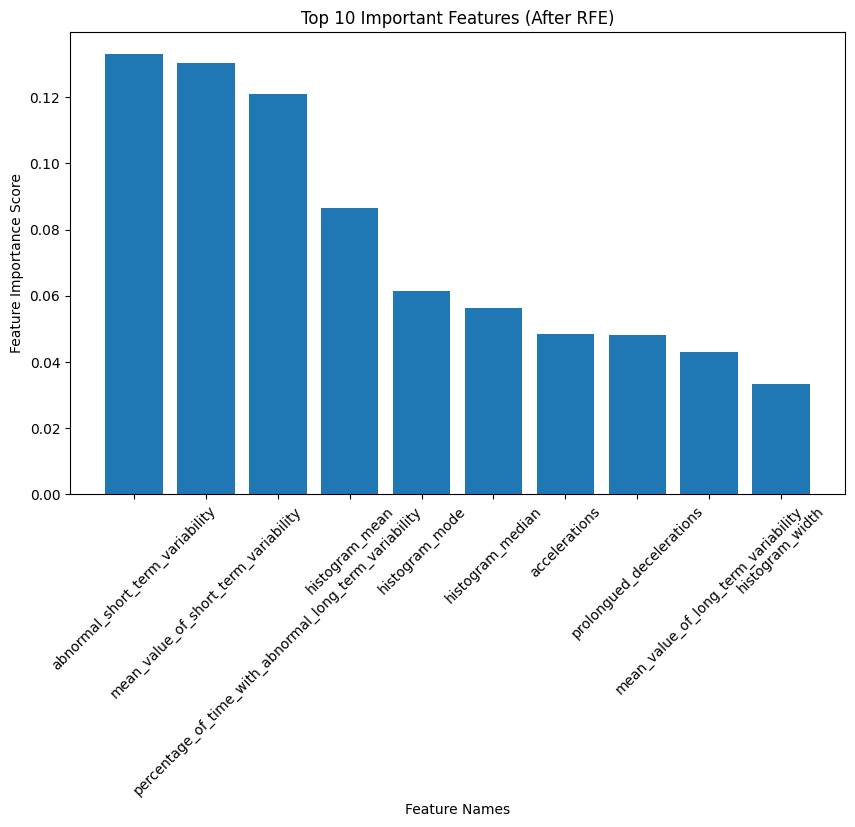

In [ ]:
# 2 Feature Selection Using RFE
rfe_selector = RFE(rf_model, n_features_to_select=10)
X_selected = rfe_selector.fit_transform(X, y)
selected_features = X.columns[rfe_selector.support_]

# 3 Feature Importance Graph AFTER RFE (Selected Features)
selected_importance = feature_importance[rfe_selector.support_]
sorted_idx_selected = np.argsort(selected_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_features)), selected_importance[sorted_idx_selected], align='center')
plt.xticks(range(len(selected_features)), np.array(selected_features)[sorted_idx_selected], rotation=45)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance Score')
plt.title('Top 10 Important Features (After RFE)')
plt.show()

In [ ]:
print(selected_features)

Index(['accelerations', 'prolongued_decelerations',
       'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_mode', 'histogram_mean', 'histogram_median'],
      dtype='object')


In [ ]:
# 4 Apply SMOTE (Balancing the Classes)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# 5 Standardize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 6 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

Stacking Classifier Accuracy: 0.9798590130916415
Stacking Classifier Precision: 0.98001554001554


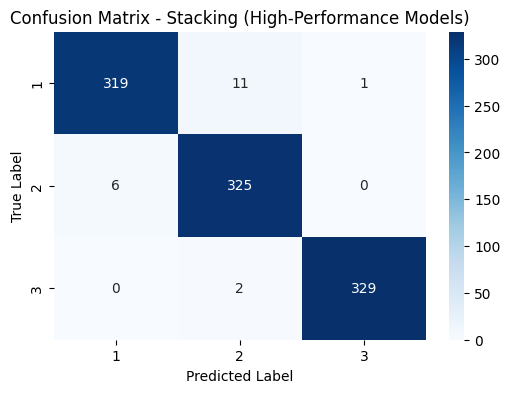


Classification Report:
               precision    recall  f1-score   support

         1.0       0.98      0.96      0.97       331
         2.0       0.96      0.98      0.97       331
         3.0       1.00      0.99      1.00       331

    accuracy                           0.98       993
   macro avg       0.98      0.98      0.98       993
weighted avg       0.98      0.98      0.98       993



In [ ]:
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib

# Suppress warnings
warnings.filterwarnings("ignore")

# # Assuming X_selected and y are your initial feature and target arrays
# # Replace these with your actual data loading if needed
# # For example: X_selected, y = load_your_data()

# # Step 4: Apply SMOTE (Balancing the Classes)
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# # Step 5: Standardize the Data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_resampled)

# # Step 6: Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
# )

# Step 1: Define High-Performance Base Models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=100, random_state=42, verbose=-1))
]

# Step 2: Define Meta-Model
meta_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Step 3: Create & Train Stacking Classifier
stacking_clf_high = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_clf_high.fit(X_train, y_train)

# Step 4: Make Predictions on Test Set
y_pred_high = stacking_clf_high.predict(X_test)

# Step 5: Evaluate Performance
accuracy_high = accuracy_score(y_test, y_pred_high)
precision_high = precision_score(y_test, y_pred_high, average='weighted')
print("Stacking Classifier Accuracy:", accuracy_high)
print("Stacking Classifier Precision:", precision_high)

# Step 6: Confusion Matrix
conf_matrix_high = confusion_matrix(y_test, y_pred_high)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_high, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Stacking (High-Performance Models)")
plt.show()

# Step 7: Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_high))

In [ ]:
# Save the model and scaler
joblib.dump(stacking_clf_high, "high_performance_stacking.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model and Scaler saved successfully!")

# Manual Testing
manual_samples = np.array([
    [0.006, 0, 17, 2.1, 0.0, 10.4, 130, 141, 136, 140],#1
    [0, 0, 73.0, 0.5, 43, 2.4, 64, 120, 137, 121.0],#2
    [0.001, 0.002, 26.0, 5.9, 0.0, 0.0, 150.0, 76.0, 107.0, 107.0],#3
    [0, 0, 64, 1.9, 9, 27.6, 130, 150, 148, 151],#2
    [0.001, 0.003, 29, 6.3, 0, 0, 150, 71, 107, 106],#3
    [.007, 0, 16, 2.4, 0, 19.9, 117, 137, 136, 138],#1
         [0.003, 0, 30, 1.5, 0.0, 5.3, 102, 147, 137, 144],#1
    [0, 0, 75, 0.3, 49, 4.6, 9, 143, 141, 143],#2
    [0.001, 0.001, 62, 2.2, 0, 0, 161, 60, 89, 113]#3

])

# Scale manual samples with the same scaler
manual_samples_scaled = scaler.transform(manual_samples)

# Predict probabilities
y_probs = stacking_clf_high.predict_proba(manual_samples_scaled)

# Define label mapping
health_conditions = {1: "Normal", 2: "Suspect", 3: "Pathological"}

# Print raw predictions
for i, probs in enumerate(y_probs):
    predicted_class = np.argmax(probs) + 1
    print(f"\nSample {i+1} → Probabilities: {probs}")
    print(f"Sample {i+1} → Predicted: {health_conditions[predicted_class]}")

# Debugging: Compare feature distributions
print("\nX_train mean:", np.mean(X_train, axis=0))
print("X_train std:", np.std(X_train, axis=0))
print("Manual samples mean:", np.mean(manual_samples, axis=0))
print("Manual samples std:", np.std(manual_samples, axis=0))

Model and Scaler saved successfully!

Sample 1 → Probabilities: [9.94910647e-01 4.63468032e-03 4.54672306e-04]
Sample 1 → Predicted: Normal

Sample 2 → Probabilities: [0.01597947 0.98012987 0.00389066]
Sample 2 → Predicted: Suspect

Sample 3 → Probabilities: [0.00699031 0.00562422 0.98738547]
Sample 3 → Predicted: Pathological

Sample 4 → Probabilities: [0.01194939 0.9844902  0.00356041]
Sample 4 → Predicted: Suspect

Sample 5 → Probabilities: [0.00438697 0.00320544 0.99240759]
Sample 5 → Predicted: Pathological

Sample 6 → Probabilities: [9.94598520e-01 4.92901173e-03 4.72467834e-04]
Sample 6 → Predicted: Normal

Sample 7 → Probabilities: [9.94915478e-01 4.63085430e-03 4.53667728e-04]
Sample 7 → Predicted: Normal

Sample 8 → Probabilities: [0.01251791 0.98343047 0.00405162]
Sample 8 → Predicted: Suspect

Sample 9 → Probabilities: [0.00385753 0.00227776 0.99386471]
Sample 9 → Predicted: Pathological

X_train mean: [ 0.00402603 -0.00954799 -0.00413101 -0.01181707  0.01379118  0.00201329

SHAP

X_test_df shape: (993, 10)
shap_values shape: (993, 10, 3)
shap_values[:, :, 2] shape: (993, 10)


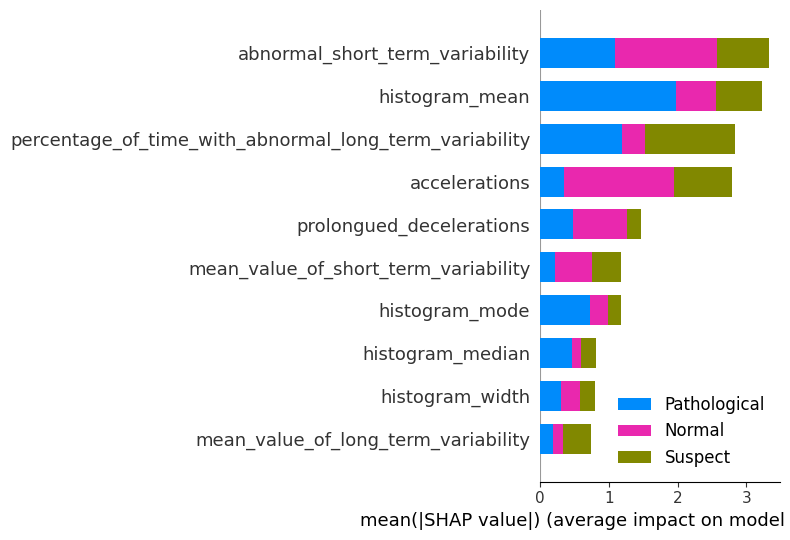

SHAP visualizations generated!


<Figure size 640x480 with 0 Axes>

In [ ]:
import joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Load model and scaler
# stacking_clf_high = joblib.load("high_performance_stacking.pkl")
# scaler = joblib.load("scaler.pkl")

# Feature names after RFE
feature_names = [
    'accelerations', 'prolongued_decelerations', 'abnormal_short_term_variability',
    'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability',
    'mean_value_of_long_term_variability', 'histogram_width', 'histogram_mode',
    'histogram_mean', 'histogram_median'
]

# Convert to DataFrames
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Debug input
print("X_test_df shape:", X_test_df.shape)

# SHAP Explainer
explainer = shap.TreeExplainer(stacking_clf_high.named_estimators_['lgbm'])
shap_values = explainer.shap_values(X_test_df)

# Debug SHAP output
print("shap_values shape:", shap_values.shape)
print("shap_values[:, :, 2] shape:", shap_values[:, :, 2].shape)

# Visualizations
# Summary plot (bar) for all classes requires a list, so we need to split manually
#shap.summary_plot([shap_values[:, :, i] for i in range(3)], X_test_df, plot_type="bar")
shap.summary_plot([shap_values[:, :, i] for i in range(3)], X_test_df, plot_type="bar", class_names=["Normal", "Suspect", "Pathological"])
plt.savefig("shap_summary.png")


print("SHAP visualizations generated!")

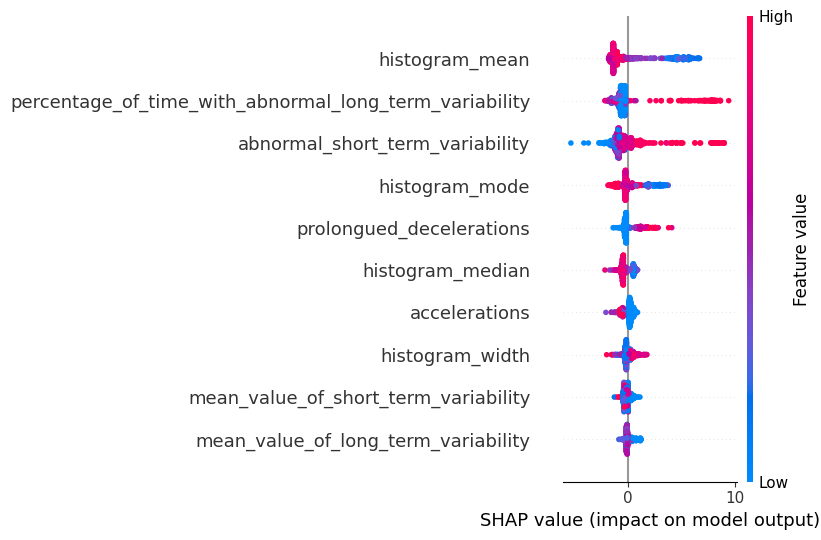

<Figure size 640x480 with 0 Axes>

In [ ]:
# Beeswarm plot for Pathological (class 3)
shap.summary_plot(shap_values[:, :, 2], X_test_df)
plt.savefig("shap_beeswarm_pathological.png")

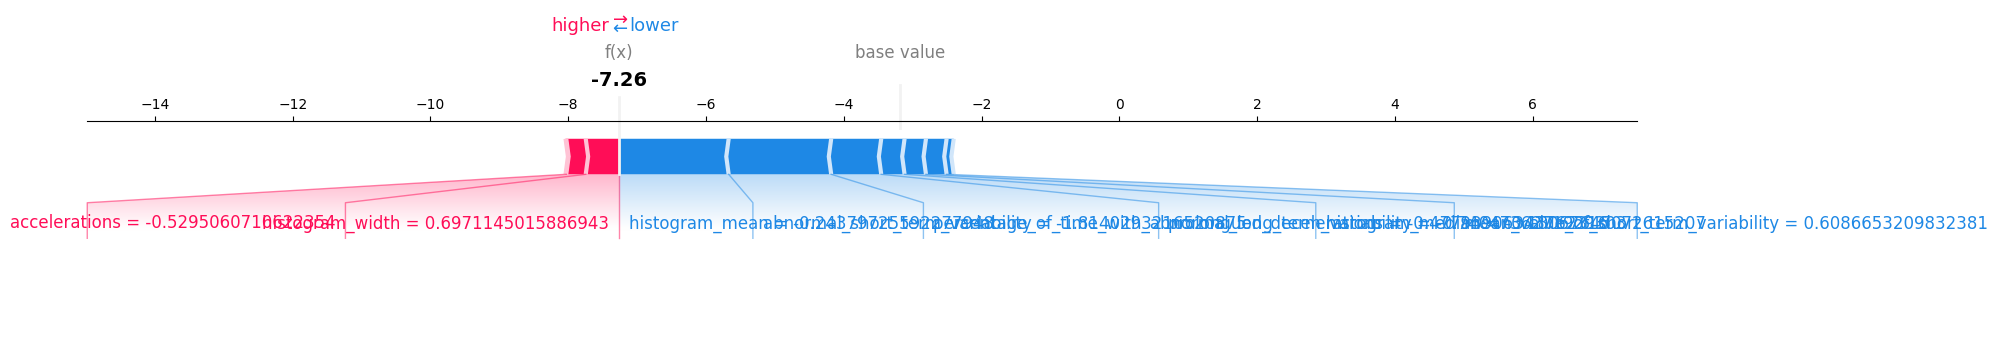

<Figure size 640x480 with 0 Axes>

In [ ]:
# Force plot for first sample, Pathological class
shap.force_plot(explainer.expected_value[2], shap_values[0, :, 2], X_test_df.iloc[0], matplotlib=True)
plt.savefig("shap_force_sample1.png")